# Drug Targeting different nodes of the 524 cascade system

## Init

In [2]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [3]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [4]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

In [12]:
import os 

### parameters 

notebook_name = 'drug_targeting_524'
plot_figures = True
run_jobs = False
parallelise = True
save_figures = True

## Generation of ground truth model 

model_name = 'v3_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 1000
simulation_step = 100

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/drug_targeting_524_4_50/


## Jobs and Visualisations

### Generate drug network

In [6]:
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(4, 5, 2, verbose=0)
G0_d = model_drug_spec.generate_network('drug_model_524', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)

In [7]:
print(model_drug_spec.get_feedback_regulations())

[('C', 'A1'), ('B0', 'A2')]


In [8]:
drug_activation_time = 500
drug_value = 5000

possible_drugs = []
counter = 0 
for specie in model_drug_spec.A_species:
    drug = Drug('D'+str(counter)+'_'+specie+'d', drug_activation_time, drug_value)
    drug.add_regulation(specie, 'down')
    possible_drugs.append(drug)
    drug = Drug('D'+str(counter)+'_'+specie+'u', drug_activation_time, drug_value)
    drug.add_regulation(specie, 'up')
    possible_drugs.append(drug)
    counter += 1

for specie in model_drug_spec.B_species:
    drug = Drug('D'+str(counter)+'_'+specie+'d', drug_activation_time, drug_value)
    drug.add_regulation(specie, 'down')
    possible_drugs.append(drug)
    drug = Drug('D'+str(counter)+'_'+specie+'u', drug_activation_time, drug_value)
    drug.add_regulation(specie, 'up')   
    possible_drugs.append(drug)
    counter += 1
    
drug = Drug('D'+str(counter)+'_C', drug_activation_time, drug_value)
drug.add_regulation('C', 'down')
possible_drugs.append(drug)

drug = Drug('D'+str(counter)+'_C', drug_activation_time, drug_value)
drug.add_regulation('C', 'up')
possible_drugs.append(drug)
    
for drug in possible_drugs:
    print(drug)

Drug(D0_A0d, 500, ['A0'], ['down'])
Drug(D0_A0u, 500, ['A0'], ['up'])
Drug(D1_A1d, 500, ['A1'], ['down'])
Drug(D1_A1u, 500, ['A1'], ['up'])
Drug(D2_A2d, 500, ['A2'], ['down'])
Drug(D2_A2u, 500, ['A2'], ['up'])
Drug(D3_A3d, 500, ['A3'], ['down'])
Drug(D3_A3u, 500, ['A3'], ['up'])
Drug(D4_A4d, 500, ['A4'], ['down'])
Drug(D4_A4u, 500, ['A4'], ['up'])
Drug(D5_B0d, 500, ['B0'], ['down'])
Drug(D5_B0u, 500, ['B0'], ['up'])
Drug(D6_B1d, 500, ['B1'], ['down'])
Drug(D6_B1u, 500, ['B1'], ['up'])
Drug(D7_B2d, 500, ['B2'], ['down'])
Drug(D7_B2u, 500, ['B2'], ['up'])
Drug(D8_B3d, 500, ['B3'], ['down'])
Drug(D8_B3u, 500, ['B3'], ['up'])
Drug(D9_B4d, 500, ['B4'], ['down'])
Drug(D9_B4u, 500, ['B4'], ['up'])
Drug(D10_C, 500, ['C'], ['down'])
Drug(D10_C, 500, ['C'], ['up'])


In [9]:
diff_model_specs = []
diff_models = []
for drug in possible_drugs:
    new_drug_spec = DrugModelSpecification()
    new_drug_spec.generate_specifications(4, 5, 2, verbose=0)
    new_drug_spec.add_drug(drug)
    new_model = new_drug_spec.generate_network(f'drug_model_524_{drug.name}', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)
    new_model = copy_over_params_states(G0_d, new_model)
    diff_model_specs.append(new_drug_spec)
    diff_models.append(new_model)

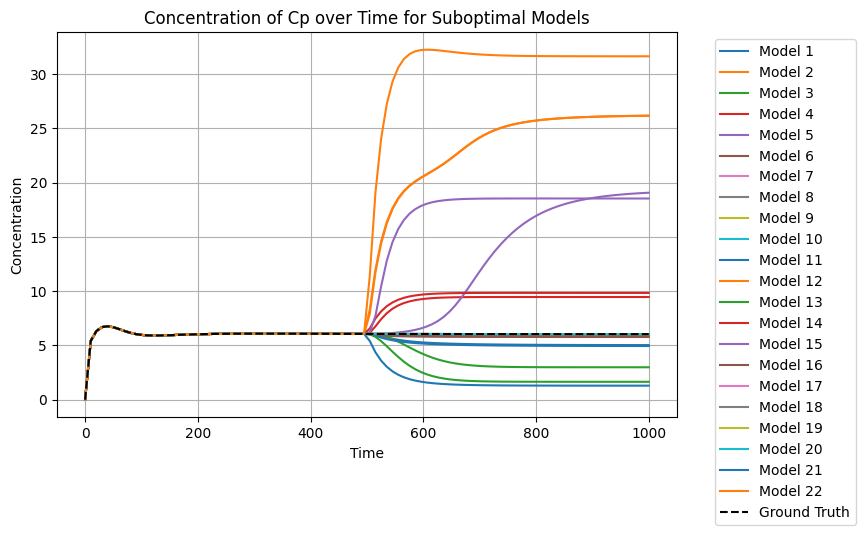

In [13]:
# perform simulations on each of the models 
import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

if plot_figures:
    # Visualise the behaviour of the suboptimal models, plot the original model as reference comparison
    plt.figure(figsize=(8, 5))

    for i, s_model in enumerate(diff_models):
        runner = roadrunner.RoadRunner(s_model.get_sbml_model())
        res = runner.simulate(0, simulation_time, simulation_step)
        plt.plot(res['time'], res['[Cp]'], label=f"Model {i+1}")
        
    runner = roadrunner.RoadRunner(G0_d.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    plt.plot(res['time'], res['[Cp]'], label="Ground Truth", linestyle='dashed', color='black')
        
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Concentration of Cp over Time for Suboptimal Models")
    plt.grid(True)
    # set the legend to be outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()